In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import seaborn as sns
import json
import torch
import pickle

import matplotlib
matplotlib.rcParams.update({'font.size': 14})
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DeJavu Serif"


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-s5i0qgy8 because the default path (/afs/cs.stanford.edu/u/mfchen/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
df_all = pd.DataFrame()

In [3]:
perp_folders = ["../output/10192023/"]

In [4]:

for perp_folder in perp_folders:
    files = os.listdir(perp_folder)
    files = [os.path.join(perp_folder, f) for f in files] # add path to each file
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    
    for file in files:        
        if "opposite" in file or "emb" in file or "predictions" in file or "proportions" in file or "labels" in file or "curriculum.pkl" in file:
            continue 
                
        if ".log" in file:
            continue
        method = file.split("/")[-1]
        
        runs = os.listdir(file)
        
        for run in runs:
            if "labels" in run or "curriculum" in run or "proportions" in run or "predictions" in run or "emb" in run:
                continue 
            seed = int(run.split("seed_")[-1].split("_")[0])
            checkpoint = int(run.split("-")[-1].split(".")[0])
            if len(df_all) != 0:
                if len(df_all.loc[(df_all.method==method) & (df_all.seed == seed) & (df_all.index==checkpoint)]) != 0:
                    continue 
                
            path = os.path.join(file, run)
            print(path)
                
            loss_dict = pd.read_pickle(path)

            df = pd.DataFrame([{"skill": k, "loss": [values.numpy() if torch.is_tensor(values) else values for values in v]} for k, v in loss_dict.items()])
            df["perplexity"] = pd.Series([np.exp(l) for l in df["loss"].values])
            df["average_loss"] = pd.Series([sum(l)/len(l) for l in df["loss"].values])
            df["average_perplexity"] = pd.Series([sum(p)/len(p) for p in df["perplexity"].values])
            df["method"] = method
            df["seed"] = seed
            df["checkpoint"] = checkpoint


            df.set_index("checkpoint", inplace=True)


            df_all = pd.concat([df_all, df])


../output/10192023/addition_3_192000_mixture_weights_543_static/seed_2_checkpoint-4800.pkl
../output/10192023/addition_3_192000_mixture_weights_543_static/seed_3_checkpoint-1500.pkl
../output/10192023/addition_3_192000_mixture_weights_543_static/seed_4_checkpoint-5700.pkl
../output/10192023/addition_3_192000_mixture_weights_543_static/seed_4_checkpoint-3800.pkl


../output/10192023/addition_3_192000_mixture_weights_543_static/seed_2_checkpoint-2700.pkl
../output/10192023/addition_3_192000_mixture_weights_543_static/seed_0_checkpoint-4300.pkl
../output/10192023/addition_3_192000_mixture_weights_543_static/seed_0_checkpoint-0.pkl
../output/10192023/addition_3_192000_mixture_weights_543_static/seed_4_checkpoint-1900.pkl
../output/10192023/addition_3_192000_mixture_weights_543_static/seed_3_checkpoint-3400.pkl
../output/10192023/addition_3_192000_mixture_weights_543_static/seed_1_checkpoint-5000.pkl
../output/10192023/addition_3_192000_mixture_weights_543_static/seed_1_checkpoint-3300.pkl
../output/10192023/addition_3_192000_mixture_weights_543_static/seed_3_checkpoint-5700.pkl
../output/10192023/addition_3_192000_mixture_weights_543_static/seed_4_checkpoint-1500.pkl
../output/10192023/addition_3_192000_mixture_weights_543_static/seed_3_checkpoint-3800.pkl
../output/10192023/addition_3_192000_mixture_weights_543_static/seed_1_checkpoint-1200.pkl
..

In [5]:
def aggregate_task_category(x, ppl=True):
    if ppl:
        total_ppl = x["perplexity"].apply(lambda x: sum(x)).sum()
        count_ppl = x["perplexity"].apply(lambda x: len(x)).sum()
        metric_name = "task_perplexity"
        metric = total_ppl/count_ppl
        
        var_numerator = x["perplexity"].apply(lambda x: sum((x - metric)**2)).sum()
        std = np.sqrt(var_numerator / count_loss)

        total_ppl_opposite = x["opposite_perplexity"].apply(lambda x: sum(x)).sum()
        count_ppl_opposite = x["opposite_perplexity"].apply(lambda x: len(x)).sum()
        metric_name_opposite = "task_perplexity_opposite"
        metric_opposite = total_ppl_opposite/count_ppl_opposite
    else:
        total_loss = x["loss"].apply(lambda x: sum(x)).sum()
        count_loss = x["loss"].apply(lambda x: len(x)).sum()
        metric_name = "task_loss"
        metric = total_loss/count_loss
        
        
        var_numerator = x["loss"].apply(lambda x: sum((x - metric)**2)).sum()
        std = np.sqrt(var_numerator / count_loss)

    names = {metric_name: metric,
             "stddev": std}
    
    return pd.Series(names, index=[metric_name, "stddev"])


In [6]:
sorted(df_all.method.unique())

['addition_3_192000_mixture_weights_131418_static',
 'addition_3_192000_mixture_weights_543_static',
 'addition_3_192000_stratified_static',
 'addition_3_6000_mixture_graph_100110001_greedy_1200_eta_0.1_lookback_3_checkpoints',
 'addition_3_anticurriculum_192000_mixture_weights_131418_static',
 'addition_3_curriculum_192000_mixture_weights_131418_static',
 'addition_3_group_anticurriculum_mixingfrac_0.0_192000_stratified_static',
 'addition_3_group_anticurriculum_mixingfrac_0.4_192000_stratified_static',
 'addition_3_group_curriculum_mixingfrac_0.0_192000_stratified_static',
 'addition_3_group_curriculum_mixingfrac_0.4_192000_stratified_static']

In [7]:
matplotlib.rcParams.update({'font.size': 24})


2 2
[1 2 3 4 0]
[2 4 0 1 3]
[4 0 1 3 2]
[0 3 2 1 4]
[4 2 3 0 1]
[0 3 1 2 4]
[1 3 4 2 0]


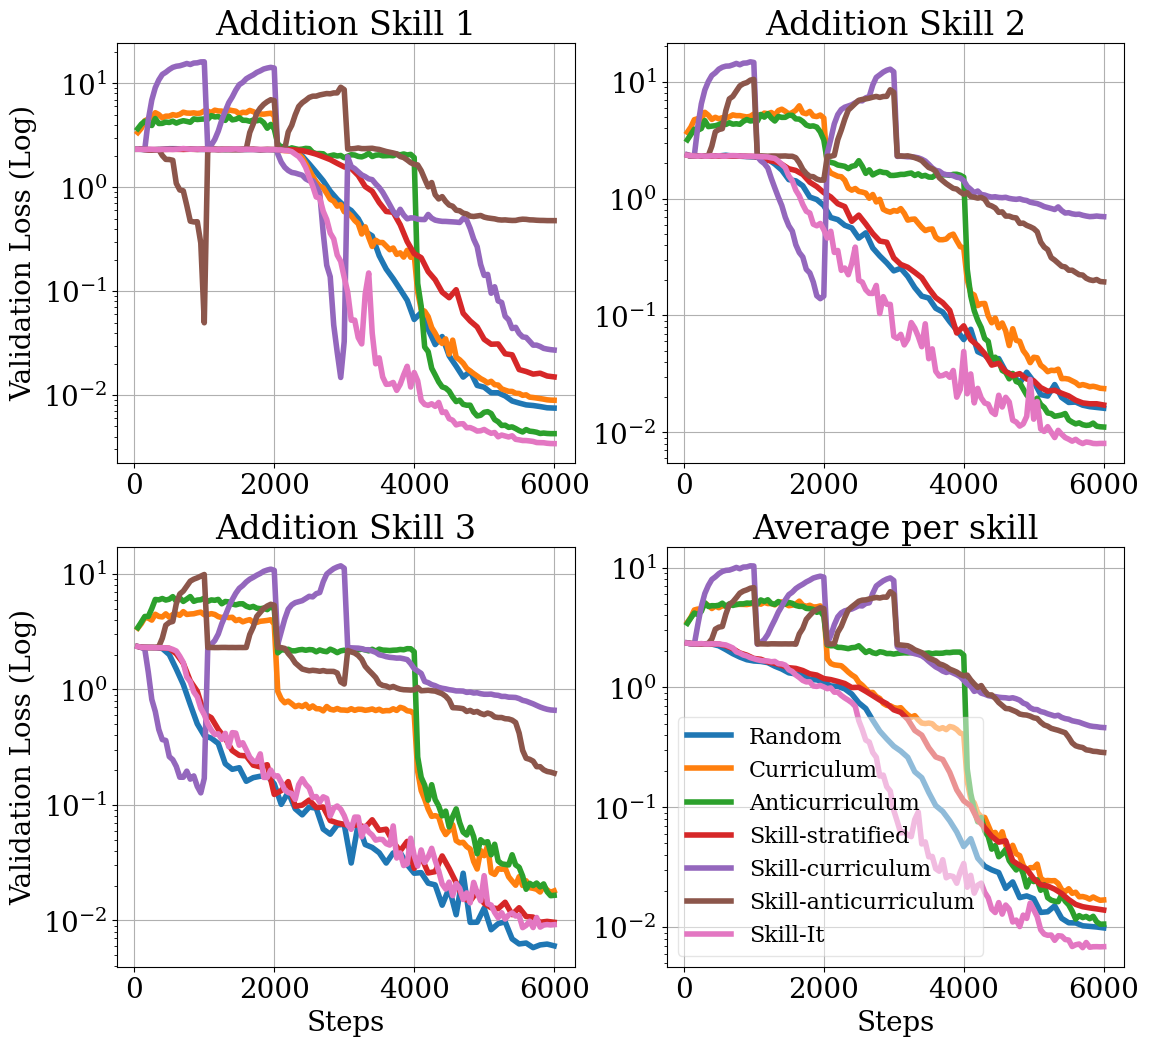

In [ ]:
n_var = 4

nrow = 2
ncol = int(np.ceil(n_var / nrow))
print(nrow, ncol)

figure, axis = plt.subplots(nrow, ncol, figsize=(13, 12))


methods = [ "addition_3_192000_mixture_weights_131418_static", 
           "addition_3_curriculum_192000_mixture_weights_131418_static",
           "addition_3_anticurriculum_192000_mixture_weights_131418_static",
           "addition_3_192000_stratified_static",
           "addition_3_group_curriculum_mixingfrac_0.0_192000_stratified_static",
           "addition_3_group_anticurriculum_mixingfrac_0.0_192000_stratified_static",
           "addition_3_6000_mixture_graph_100110001_greedy_1200_eta_0.1_lookback_3_checkpoints"
]

labels = [ "Random", "Curriculum", "Anticurriculum", "Skill-stratified", "Skill-curriculum", "Skill-anticurriculum", "Skill-It"]



for k, method in enumerate(methods):

    df_weighted = df_all.loc[df_all.method ==  method].sort_index()
    print(df_weighted.seed.unique())
    
    if method == "192000":
        filtered_idxs = np.arange(0, 6060, 60)
        df_weighted = df_weighted.loc[df_weighted.index.isin(filtered_idxs)]

    df_weighted_overall =  df_weighted.groupby([df_weighted.index]).apply(lambda x: aggregate_task_category(x, ppl=False)).reset_index()
    df_weighted_overall.set_index("checkpoint", inplace=True)
    if df_weighted_overall.index.min() == 0:
        df_weighted_overall.drop([0], inplace=True)

    df_weighted = df_weighted.groupby([df_weighted.index, "skill"]).apply(lambda x: aggregate_task_category(x, ppl=False)).reset_index()
    df_weighted.set_index("checkpoint", inplace=True)

    task_idxs = df_weighted.skill.unique()

    for idx, t in enumerate(task_idxs):
        i = int(idx / ncol)
        j = int(idx % ncol)
        df_task_weighted = df_weighted.loc[(df_weighted.skill == t) & (df_weighted.index > 0)]
    
        df_task_weighted.task_loss.plot(legend=False, label=labels[k], ax=axis[idx], lw=4)

        axis[i, 0].set_ylabel("Validation Loss (Log)")
        axis[i, j].set_title(f"Addition Skill {int(t+1)}")
        axis[i, j].grid()        
        if i != -1:
            axis[i, j].set_xlabel("")
        axis[-1, j].set_xlabel("Steps")
        
        axis[i, j].set_yscale("log")
        
    idx += 1
    i = int(idx / ncol)
    j = int(idx % ncol)
    df_weighted_overall.task_loss.plot(legend=True, label=labels[k], ax=axis[i,j], lw=4)
    axis[i, j].set_title("Average per skill")
    axis[i, j].set_xlabel("Steps")
    axis[i, j].grid()
    
    axis[i, j].set_yscale("log")
    
    axis[i, j].legend(loc = "lower left", fontsize=16, fancybox=True, framealpha=0.5)



plt.savefig("../figs/addn_mw_large_font.pdf", bbox_inches="tight")

1 4
[1 2 3 4 0]
[2 4 0 1 3]
[4 0 1 3 2]
[0 3 2 1 4]
[4 2 3 0 1]
[0 3 1 2 4]
[1 3 4 2 0]


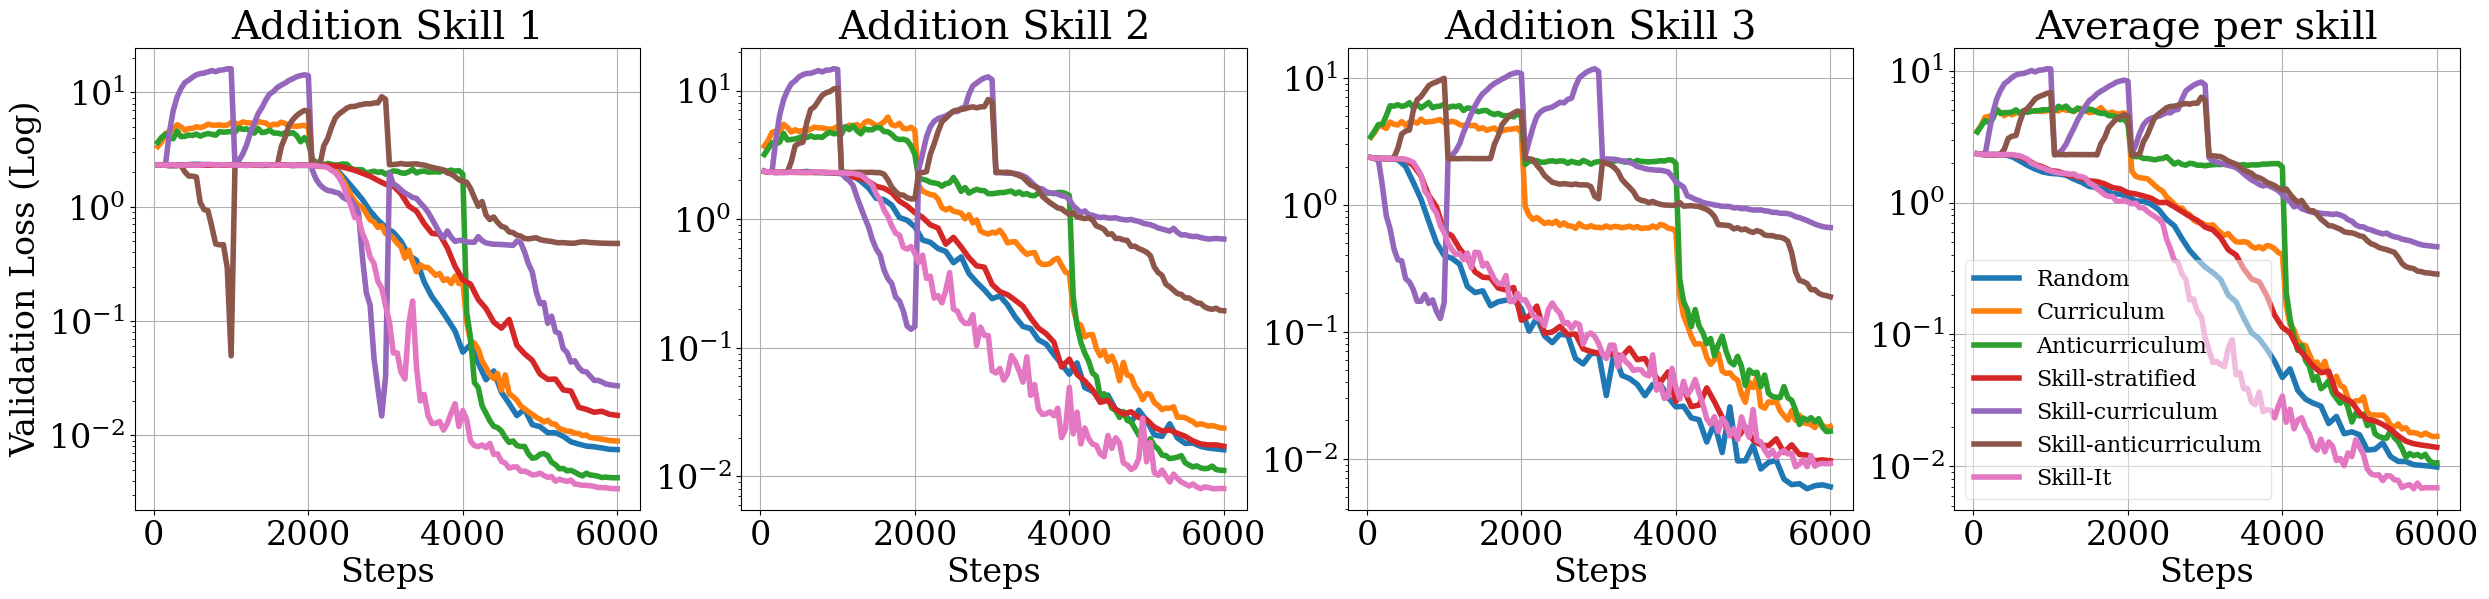

In [26]:
n_var = 4

nrow = 1
ncol = int(np.ceil(n_var / nrow))
print(nrow, ncol)

figure, axis = plt.subplots(nrow, ncol, figsize=(30, 6))


methods = [ "addition_3_192000_mixture_weights_131418_static", 
           "addition_3_curriculum_192000_mixture_weights_131418_static",
           "addition_3_anticurriculum_192000_mixture_weights_131418_static",
           "addition_3_192000_stratified_static",
           "addition_3_group_curriculum_mixingfrac_0.0_192000_stratified_static",
           "addition_3_group_anticurriculum_mixingfrac_0.0_192000_stratified_static",
           "addition_3_6000_mixture_graph_100110001_greedy_1200_eta_0.1_lookback_3_checkpoints"
]

labels = [ "Random", "Curriculum", "Anticurriculum", "Skill-stratified", "Skill-curriculum", "Skill-anticurriculum", "Skill-It"]



for k, method in enumerate(methods):

    df_weighted = df_all.loc[df_all.method ==  method].sort_index()
    print(df_weighted.seed.unique())
    
    if method == "192000":
        filtered_idxs = np.arange(0, 6060, 60)
        df_weighted = df_weighted.loc[df_weighted.index.isin(filtered_idxs)]

    df_weighted_overall =  df_weighted.groupby([df_weighted.index]).apply(lambda x: aggregate_task_category(x, ppl=False)).reset_index()
    df_weighted_overall.set_index("checkpoint", inplace=True)
    if df_weighted_overall.index.min() == 0:
        df_weighted_overall.drop([0], inplace=True)

    df_weighted = df_weighted.groupby([df_weighted.index, "skill"]).apply(lambda x: aggregate_task_category(x, ppl=False)).reset_index()
    df_weighted.set_index("checkpoint", inplace=True)

    task_idxs = df_weighted.skill.unique()

    for idx, t in enumerate(task_idxs):
        df_task_weighted = df_weighted.loc[(df_weighted.skill == t) & (df_weighted.index > 0)]
        df_task_weighted.task_loss.plot(legend=False, label=labels[k], ax=axis[idx], lw=4)

        axis[0].set_ylabel("Validation Loss (Log)")

        axis[idx].set_title(f"Addition Skill {int(t+1)}")
        
        axis[idx].grid()

        axis[idx].set_xlabel("")
        axis[idx].set_xlabel("Steps")
        axis[idx].set_yscale("log")

    idx += 1
    df_weighted_overall.task_loss.plot(legend=True, label=labels[k], ax=axis[idx], lw=4)
    axis[idx].set_title("Average per skill")
    axis[idx].set_xlabel("Steps")
    axis[idx].grid()
    
    axis[idx].set_yscale("log")
    
    axis[idx].legend(loc = "lower left", fontsize=16, fancybox=True, framealpha=0.5)



plt.savefig("../figs/addn_mw_horizontal.pdf", bbox_inches="tight")

In [17]:
for method in methods:
    print(f"Method: {method}")
    df_weighted = df_all.loc[df_all.method ==  method].sort_index()
    df_weighted = df_weighted.groupby([df_weighted.index, "skill", "seed"]).apply(lambda x: aggregate_task_category(x, ppl=False)).reset_index()
    df_weighted.set_index("checkpoint", inplace=True)
    
    idx_nearest_to_k = np.abs(df_weighted.index.unique() - 6000).argsort()[0]
    
    print(f"Seeds: {df_weighted.seed.unique()}")

    print(f"Average loss per skill: {df_weighted.loc[df_weighted.index == df_weighted.index.unique()[idx_nearest_to_k]].groupby('skill').task_loss.mean()}")
    print(f'Standard deviation per skill: {df_weighted.loc[df_weighted.index == df_weighted.index.unique()[idx_nearest_to_k]].groupby("skill").task_loss.std()}')
    print(f'Overall average loss: {df_weighted.loc[df_weighted.index == df_weighted.index.unique()[idx_nearest_to_k]].groupby("seed").task_loss.mean().mean()}')
    print(f'Overall standard deviation: {df_weighted.loc[df_weighted.index == df_weighted.index.unique()[idx_nearest_to_k]].groupby("seed").task_loss.mean().std()}')

Method: addition_3_192000_mixture_weights_131418_static
Seeds: [0 1 2 3 4]
Average loss per skill: skill
0    0.007508
1    0.016082
2    0.006015
Name: task_loss, dtype: float64
Standard deviation per skill: skill
0    0.005760
1    0.003953
2    0.001345
Name: task_loss, dtype: float64
Overall average loss: 0.009868339496300907
Overall standard deviation: 0.0028841013974482154
Method: addition_3_curriculum_192000_mixture_weights_131418_static
Seeds: [0 1 2 3 4]
Average loss per skill: skill
0    0.008931
1    0.023696
2    0.017987
Name: task_loss, dtype: float64
Standard deviation per skill: skill
0    0.005177
1    0.005801
2    0.007352
Name: task_loss, dtype: float64
Overall average loss: 0.01687153474056686
Overall standard deviation: 0.005905192017981928
Method: addition_3_anticurriculum_192000_mixture_weights_131418_static
Seeds: [0 1 2 3 4]
Average loss per skill: skill
0    0.004262
1    0.011108
2    0.016474
Name: task_loss, dtype: float64
Standard deviation per skill: ski

In [5]:
df_all_preds = pd.DataFrame()

In [6]:


for perp_folder in perp_folders:
    files = os.listdir(perp_folder)
    files = [os.path.join(perp_folder, f) for f in files] # add path to each file
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    
    for file in files: 
        if "log" in file:
            continue 
        method = file.split("/")[-1]
        runs = os.listdir(file)
        for run in runs:
            if "prediction" not in run:
                continue 
            seed = int(run.split("seed_")[-1].split("_")[0])
            checkpoint = int(run.split("-")[-1].split(".")[0])
            if len(df_all_preds) != 0:
                if len(df_all_preds.loc[(df_all_preds.method==method) & (df_all_preds.seed == seed) & (df_all_preds.index==checkpoint)]) != 0:
                    continue 
                
            path = os.path.join(file, run)
            print(path)
                
            pred_dict = pd.read_pickle(path)
        

        
            df = pd.DataFrame([{"skill": k, "prediction": [values.numpy() if torch.is_tensor(values) else values for values in v]} for k, v in pred_dict.items()])
            df["method"] = method
            df["seed"] = seed
            df["checkpoint"] = checkpoint


            df.set_index("checkpoint", inplace=True)


            df_all_preds = pd.concat([df_all_preds, df])
    

../output/10192023/addition_3_192000_mixture_weights_543_static/seed_2_predictions_checkpoint-3300.pkl
../output/10192023/addition_3_192000_mixture_weights_543_static/seed_4_predictions_checkpoint-1000.pkl
../output/10192023/addition_3_192000_mixture_weights_543_static/seed_4_predictions_checkpoint-200.pkl
../output/10192023/addition_3_192000_mixture_weights_543_static/seed_1_predictions_checkpoint-3200.pkl
../output/10192023/addition_3_192000_mixture_weights_543_static/seed_3_predictions_checkpoint-4600.pkl
../output/10192023/addition_3_192000_mixture_weights_543_static/seed_2_predictions_checkpoint-1200.pkl
../output/10192023/addition_3_192000_mixture_weights_543_static/seed_3_predictions_checkpoint-2900.pkl
../output/10192023/addition_3_192000_mixture_weights_543_static/seed_0_predictions_checkpoint-2800.pkl
../output/10192023/addition_3_192000_mixture_weights_543_static/seed_1_predictions_checkpoint-1300.pkl
../output/10192023/addition_3_192000_mixture_weights_543_static/seed_4_pre

In [7]:
methods = [ "addition_3_192000_mixture_weights_131418_static", 
           "addition_3_curriculum_192000_mixture_weights_131418_static",
           "addition_3_anticurriculum_192000_mixture_weights_131418_static",
           "addition_3_192000_stratified_static",
           "addition_3_group_curriculum_mixingfrac_0.0_192000_stratified_static",
           "addition_3_group_anticurriculum_mixingfrac_0.0_192000_stratified_static",
           "addition_3_6000_mixture_graph_100110001_greedy_1200_eta_0.1_lookback_3_checkpoints"
]

labels = [ "Random", "Curriculum", "Anticurriculum", "Skill-stratified", "Skill-curriculum", "Skill-anticurriculum", "Skill-It"]


file = "../output/10192023/addition_3_192000_stratified_static/"
label_dict = pd.read_pickle(file+"/labels.pkl")
label_df = pd.DataFrame([{"skill": k, "label": [values.numpy() if torch.is_tensor(values) else values for values in v]} for k, v in label_dict.items()])

for method in methods:
    print(method)
    df = df_all_preds.loc[df_all_preds.method == method].sort_index()
    df['accs'] = df.apply(lambda x: (np.array(x.prediction) == np.array(label_df.loc[label_df.skill == x.skill].label.values[0])).mean(), axis=1)
    
    idx_nearest_to_k = np.abs(df.index.unique() - 3000).argsort()[0]
    
    df_ckpt = df.loc[df.index==df.index.unique()[idx_nearest_to_k]]
    
    print(df_ckpt.seed.unique())
    
    print(df_ckpt.groupby("skill").accs.mean())
    print(df_ckpt.groupby("skill").accs.std())
    print(df_ckpt.groupby("seed").accs.mean().mean())
    print(df_ckpt.groupby("seed").accs.mean().std())

addition_3_192000_mixture_weights_131418_static
[3 2 0 4 1]
skill
0    0.782
1    0.916
2    0.986
Name: accs, dtype: float64
skill
0    0.368402
1    0.076354
2    0.011402
Name: accs, dtype: float64
0.8946666666666665
0.1402497771834237
addition_3_curriculum_192000_mixture_weights_131418_static
[0 1 3 2 4]
skill
0    0.810
1    0.654
2    0.826
Name: accs, dtype: float64
skill
0    0.187750
1    0.035777
2    0.029665
Name: accs, dtype: float64
0.7633333333333334
0.07898663740715188
addition_3_anticurriculum_192000_mixture_weights_131418_static
[3 2 0 4 1]
skill
0    0.784
1    0.822
2    0.708
Name: accs, dtype: float64
skill
0    0.008944
1    0.014832
2    0.016432
Name: accs, dtype: float64
0.7713333333333334
0.00691214711777588
addition_3_192000_stratified_static
[0 4 3 1 2]
skill
0    0.398
1    0.902
2    0.986
Name: accs, dtype: float64
skill
0    0.378840
1    0.062209
2    0.008944
Name: accs, dtype: float64
0.7619999999999999
0.14484857994164496
addition_3_group_curriculum

2 2
[0 2 1 4 3]
[0 4 3 2 1]
[0 2 1 3 4]
[0 1 3 4 2]
[1 3 2 0 4]
[0 2 3 1 4]
[2 0 3 1 4]


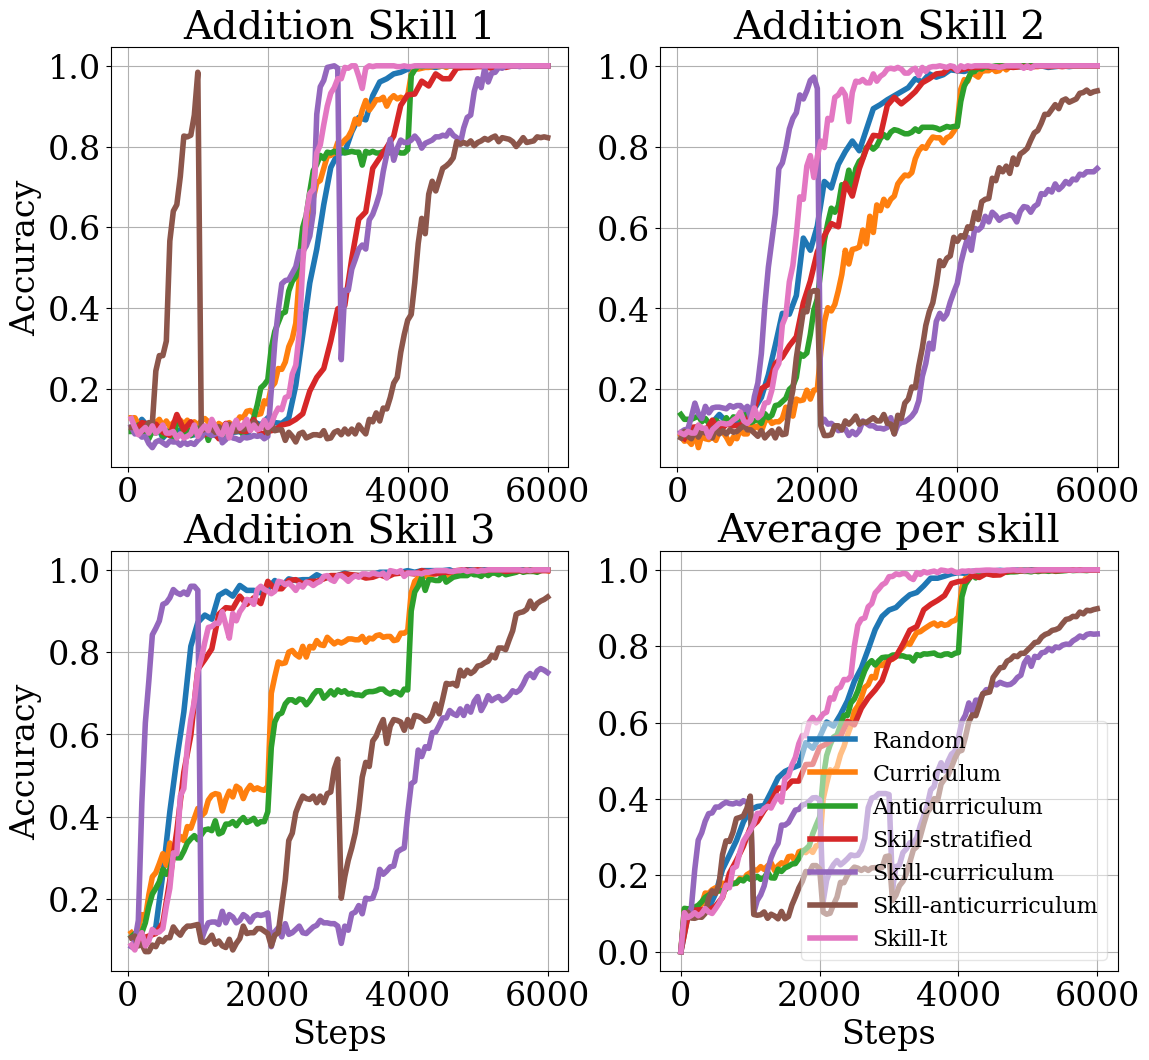

In [13]:
n_var = 4

nrow = 2
ncol = int(np.ceil(n_var / nrow))
print(nrow, ncol)

figure, axis = plt.subplots(nrow, ncol, figsize=(13, 12))


labels = ["Random", "Curriculum", "Anticurriculum", "Skill-stratified", "Skill-curriculum", "Skill-anticurriculum", "Skill-It"]


for k, method in enumerate(methods):
    df_weighted = df_all_preds.loc[df_all_preds.method ==  method].sort_index()
    print(df_weighted.seed.unique())

    df_weighted['accs'] = df_weighted.apply(lambda x: (np.array(x.prediction) == np.array(label_df.loc[label_df.skill == x.skill].label.values[0])).mean(), axis=1)        
        
    task_idxs = sorted(df_weighted.skill.unique())
    
    df_weighted_overall = df_weighted.groupby(df_weighted.index)['accs'].mean()

    for idx, t in enumerate(task_idxs):
        i = int(idx / ncol)
        j = int(idx % ncol)
        df_task_weighted = df_weighted.loc[(df_weighted.skill == t) & (df_weighted.index > 0)]
        
        df_task_weighted.groupby(df_task_weighted.index).accs.mean().plot(
            legend=False, label=labels[k], ax=axis[i, j], lw=4
        )
        axis[i, 0].set_ylabel("Accuracy")
        axis[i, j].set_title(f"Addition Skill {int(t+1)}")
        axis[i, j].grid()
        if i != -1:
            axis[i, j].set_xlabel("")
        axis[-1, j].set_xlabel("Steps")


    idx += 1
    i = int(idx / ncol)
    j = int(idx % ncol)
    df_weighted_overall.plot(
            legend=False, label=labels[k], ax=axis[i, j], lw=4
    )
    axis[i, j].set_title("Average per skill")
    axis[i, j].set_xlabel("Steps")
    axis[i, j].grid()
    
    
    axis[i, j].legend(fontsize="16", loc = "lower right", fancybox=True, framealpha=0.5)



plt.savefig("../figs/addition_accs_large_font.pdf", bbox_inches="tight")

1 4
[0 2 1 4 3]
[0 4 3 2 1]
[0 2 1 3 4]
[0 1 3 4 2]
[1 3 2 0 4]
[0 2 3 1 4]
[2 0 3 1 4]


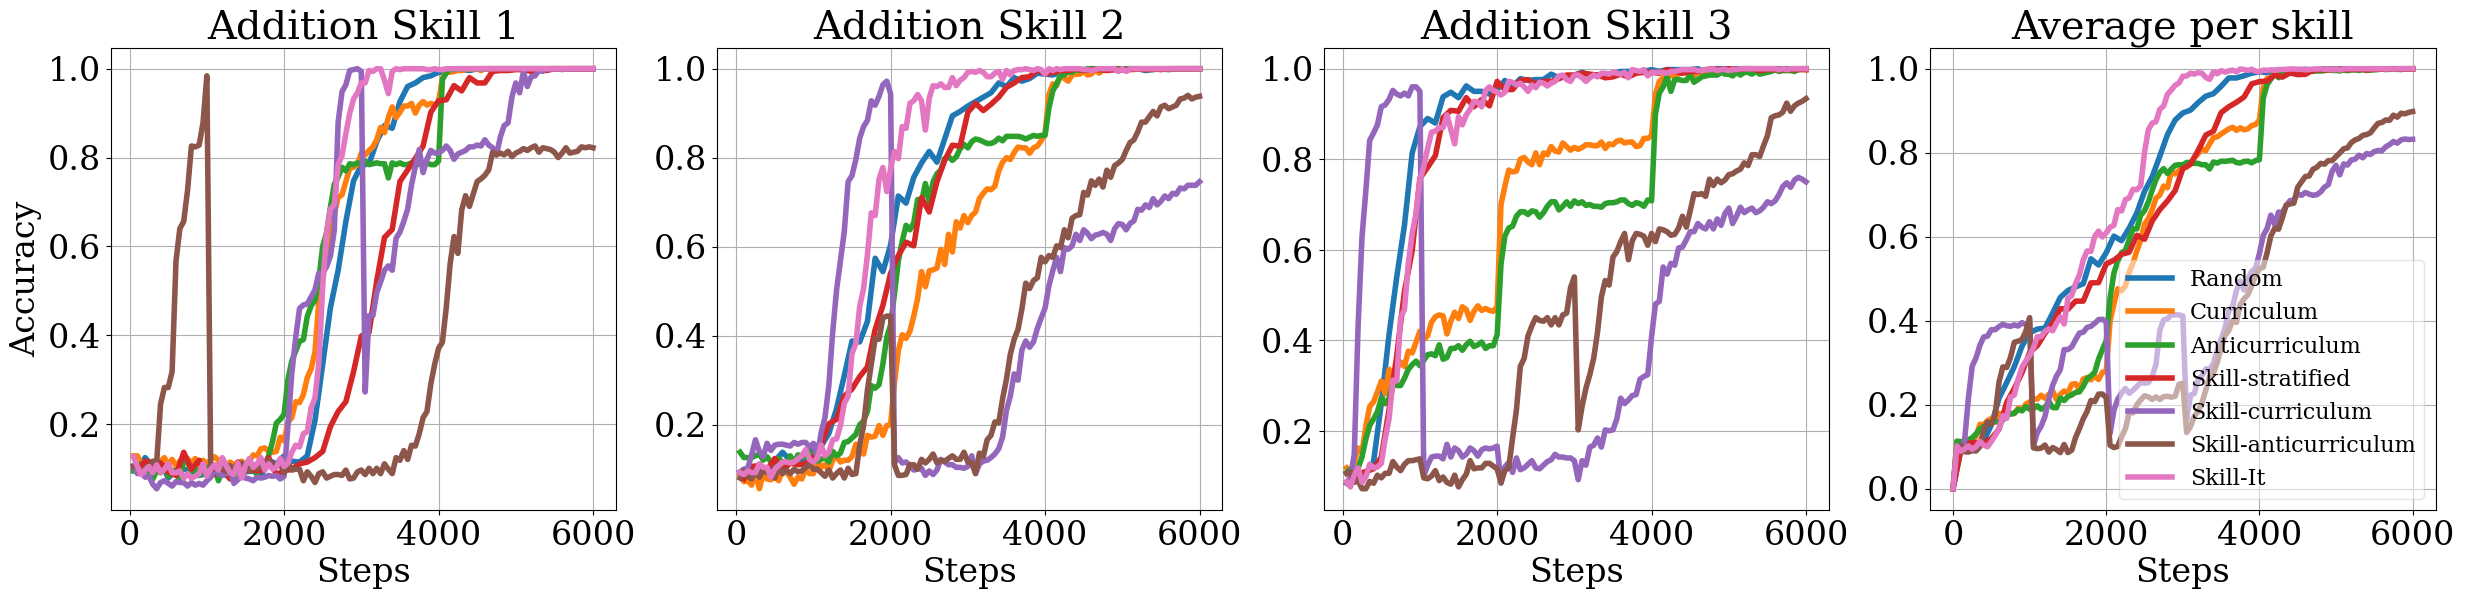

In [14]:
n_var = 4

nrow = 1
ncol = int(np.ceil(n_var / nrow))
print(nrow, ncol)

figure, axis = plt.subplots(nrow, ncol, figsize=(30, 6))


labels = ["Random", "Curriculum", "Anticurriculum", "Skill-stratified", "Skill-curriculum", "Skill-anticurriculum", "Skill-It"]


for k, method in enumerate(methods):
    df_weighted = df_all_preds.loc[df_all_preds.method ==  method].sort_index()
    print(df_weighted.seed.unique())
    df_weighted['accs'] = df_weighted.apply(lambda x: (np.array(x.prediction) == np.array(label_df.loc[label_df.skill == x.skill].label.values[0])).mean(), axis=1)        
        
    task_idxs = sorted(df_weighted.skill.unique())
    
    df_weighted_overall = df_weighted.groupby(df_weighted.index)['accs'].mean()

    for idx, t in enumerate(task_idxs):
        df_task_weighted = df_weighted.loc[(df_weighted.skill == t) & (df_weighted.index > 0)]
        
        df_task_weighted.groupby(df_task_weighted.index).accs.mean().plot(
            legend=False, label=labels[k], ax=axis[idx], lw=4
        )
        axis[0].set_ylabel("Accuracy")

        axis[idx].set_title(f"Addition Skill {int(t+1)}")
        
        axis[idx].grid()        
        axis[idx].set_xlabel("")
        axis[idx].set_xlabel("Steps")

    idx += 1
    df_weighted_overall.plot(
            legend=False, label=labels[k], ax=axis[idx], lw=4
    )
    axis[idx].set_title("Average per skill")
    axis[idx].set_xlabel("Steps")
    axis[idx].grid()
    
    
    axis[idx].legend(fontsize="16", loc = "lower right", fancybox=True, framealpha=0.5)



plt.savefig("../figs/addition_accs_horizontal.pdf", bbox_inches="tight")

1 4
[2]
[2]
[2]
[2]
[2]
[2]
[2]


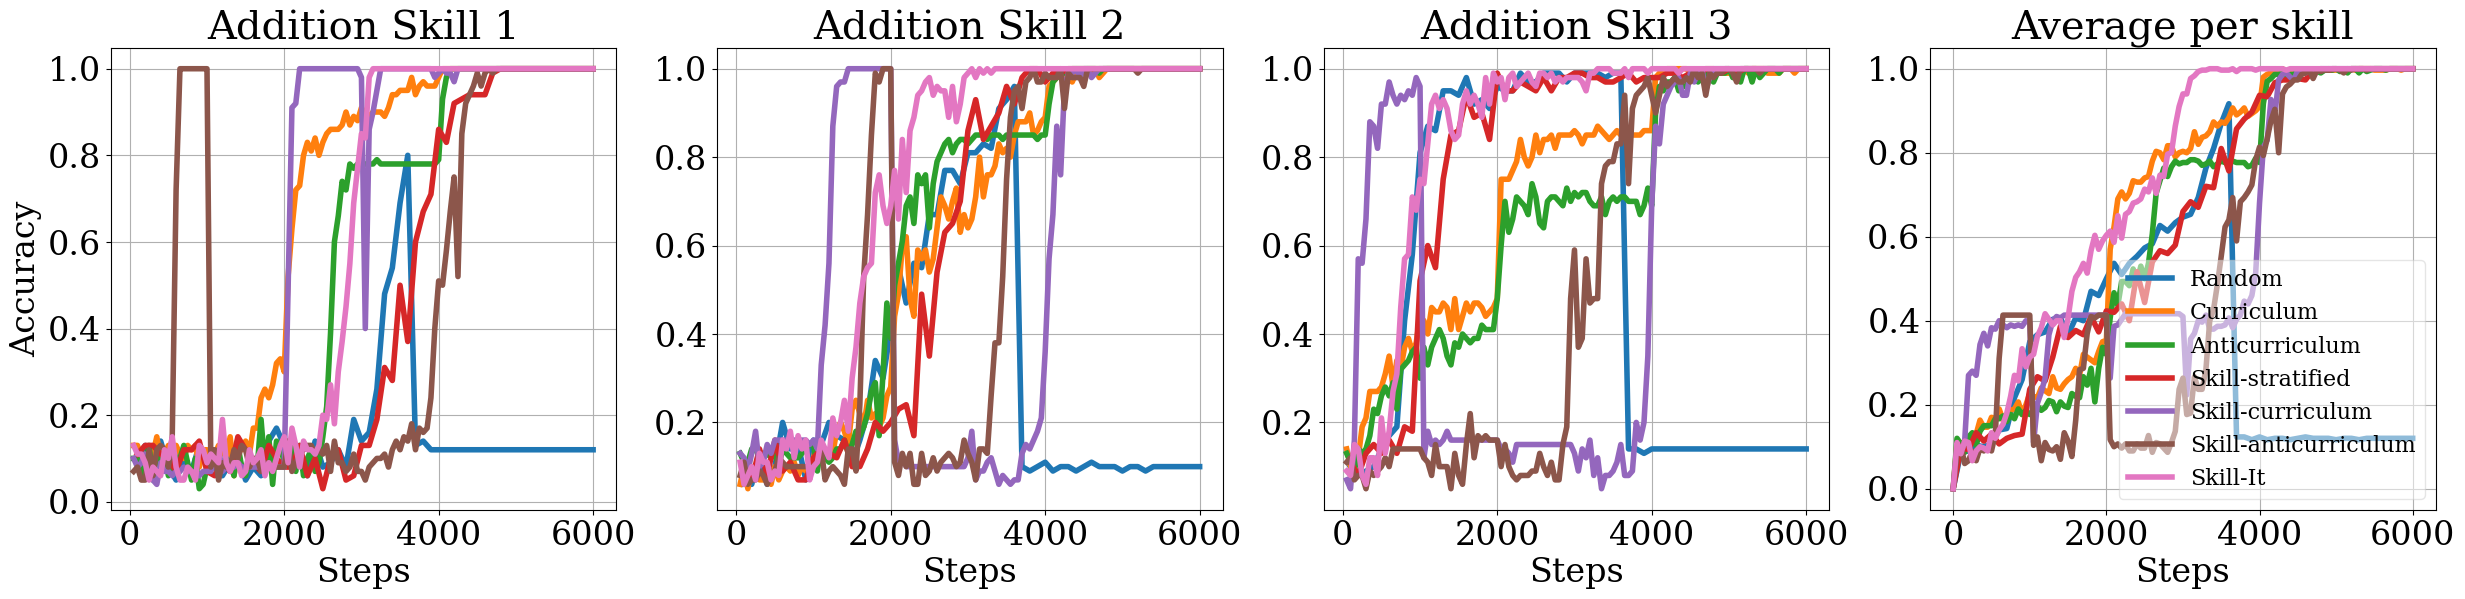

In [50]:
n_var = 4

nrow = 1
ncol = int(np.ceil(n_var / nrow))
print(nrow, ncol)

figure, axis = plt.subplots(nrow, ncol, figsize=(30, 6))


labels = ["Random", "Curriculum", "Anticurriculum", "Skill-stratified", "Skill-curriculum", "Skill-anticurriculum", "Skill-It"]


for k, method in enumerate(methods):

    df_weighted = df_all_preds.loc[(df_all_preds.method ==  method) & (df_all_preds.seed == 2)].sort_index()
    print(df_weighted.seed.unique())    

    df_weighted['accs'] = df_weighted.apply(lambda x: (np.array(x.prediction) == np.array(label_df.loc[label_df.skill == x.skill].label.values[0])).mean(), axis=1)        
        
    task_idxs = sorted(df_weighted.skill.unique())
    
    df_weighted_overall = df_weighted.groupby(df_weighted.index)['accs'].mean()

    for idx, t in enumerate(task_idxs):
        df_task_weighted = df_weighted.loc[(df_weighted.skill == t) & (df_weighted.index > 0)]
        
        df_task_weighted.groupby(df_task_weighted.index).accs.mean().plot(
            legend=False, label=labels[k], ax=axis[idx], lw=4
        )
        axis[0].set_ylabel("Accuracy")

        axis[idx].set_title(f"Addition Skill {int(t+1)}")
        axis[idx].grid()
        axis[idx].set_xlabel("")
        axis[idx].set_xlabel("Steps")

    idx += 1
    df_weighted_overall.plot(
            legend=False, label=labels[k], ax=axis[idx], lw=4
    )
    axis[idx].set_title("Average per skill")
    axis[idx].set_xlabel("Steps")
    axis[idx].grid()
    
    
    axis[idx].legend(fontsize="16", loc = "lower right", fancybox=True, framealpha=0.5)



# plt.savefig("../figs/addition_accs_horizontal.pdf", bbox_inches="tight")